# Mean Field VI & Belief Propagation

*Reference: Variational Inference for Structured NLP Models*

See: http://nlp.cs.berkeley.edu/tutorials/variational-tutorial-slides.pdf

In [13]:
import numpy as np
np.set_printoptions(precision=2)

def normalize(x):
    return x / x.sum()

## Mean Field Variational Inference

*Variational Inference for Structured NLP Models, Page. 60~68*

This is easy.

In [88]:
p_1 = np.array([0.7, 0.3])
p_2 = np.array([0.4, 0.6])
p_12 = np.array(
    [[0.2, 0.5],
     [0.2, 0.1]]
)

φ_1 = np.array([1.0, 1.0])
φ_2 = np.array([1.0, 1.0])
φ_12 = np.array(
    [[2.0, 5.0],
     [2.0, 1.0]]
)

In [94]:
q_1, q_2 = φ_1, φ_2
q_1, q_2 = normalize(q_1), normalize(q_2)
    
for iteration in range(5):
    for i in [0, 1]:        
        q_1[i] = np.exp(q_2[0] * np.log(φ_12[i][0]) + q_2[1] * np.log(φ_12[i][1]))
    q_1 = normalize(q_1)

    for i in [0, 1]:
        q_2[i] = np.exp(q_1[0] * np.log(φ_12[0][i]) + q_1[1] * np.log(φ_12[1][i]))
    q_2 = normalize(q_2)

    print("iter", iteration, q_1, q_2)

q_12 = q_1.reshape(2, 1) @ q_2.reshape(1, 2)

print(q_12)

iter 0 [0.69 0.31] [0.4 0.6]
iter 1 [0.73 0.27] [0.38 0.62]
iter 2 [0.73 0.27] [0.38 0.62]
iter 3 [0.73 0.27] [0.38 0.62]
iter 4 [0.73 0.27] [0.38 0.62]
[[0.28 0.45]
 [0.1  0.17]]


## Belief Propagation

*Variational Inference for Structured NLP Models, Page. 127~136*


Since a factor connects only two variables in this case, we use `variable-to-variable` messages instead of `variable-to-factor` and `factor-to-variable` messages.

- $ \mathrm{msg}_{A \rightarrow B} $ is a vector with dimension $|B|$, denote the message passed from A to B. 
- $ \phi_{A, B} $ denote the given potentials. 

$$
\mathrm{msg}_{A \rightarrow B} = \phi_{A, B}^\mathrm{T} \cdot \prod_{X \neq B} \mathrm{msg}_{X \rightarrow A}
$$

### Inference

- The messages are initialized as all `1`s. 
- Iteratively update messages.


The approximated probability $q$ is:

$$
q(A=a) = \frac
                { (\prod_{X} \mathrm{msg}_{X \rightarrow A})[a] }
                { \sum_a (\prod_{X} \mathrm{msg}_{X \rightarrow A})[a] }
$$


Note that although we can calculate the probabilities $q$,
- In BP, we iteratively **update messages instead of probabilities**.
- In MFVI, we update $q$ iteratively.

In [2]:
φ_0 = np.array([1.0, 1.0])
φ_1 = np.array([1.0, 1.0])
φ_2 = np.array([1.0, 1.0])
φ_3 = np.array([1.0, 1.0])
φ_01 = np.array(
    [[7, 1],
     [1, 3]]
)
φ_12 = np.array(
    [[1, 1],
     [1, 8]]
)
φ_23 = np.array(
    [[1, 9],
     [8, 1]]
)
# this line is different from the tutorial
# maybe something is wrong with that tutorial
φ_30 = np.array(
    [[6, 1],
     [2, 3]]
).T

In [127]:
class MP:
    def __init__(self, num_nodes=4) -> None:
        self._num_nodes = num_nodes
        self._msg = [[np.array([1.0, 1.0])] * num_nodes for _ in range(num_nodes)]
        self._φs = [[None] * num_nodes for _ in range(num_nodes)]
        self._φs[0][1] = φ_01
        self._φs[1][2] = φ_12
        self._φs[2][3] = φ_23
        self._φs[3][0] = φ_30

    def msg(self, idx, ex=None):
        s = 1.0
        for i in range(self._num_nodes):
            if ex == i:
                continue
            s *= self._msg[i][idx]
        return s
    
    def step(self, src, tgt):
        m_src = mp.msg(src, ex=tgt)    
        m_tgt = mp.msg(tgt, ex=src)
        mp._msg[src][tgt] = self._φs[src][tgt].T @ m_src
        mp._msg[tgt][src] = self._φs[src][tgt] @ m_tgt
        # same effect, but can prevent number overflow
        # mp._msg[src][tgt] = normalize(self._φs[src][tgt].T @ m_src)
        # mp._msg[tgt][src] = normalize(self._φs[src][tgt] @ m_tgt)
        
    def prob(self):
        ret = []
        for idx in range(self._num_nodes):
            s = self.msg(idx)
            ret.append(normalize(s))
        return ret

print("order in the tutorial")
mp = MP()
for _ in range(3):
    mp.step(0, 1); print(mp.prob())
    mp.step(1, 2); print(mp.prob())
    mp.step(3, 0); print(mp.prob())
    mp.step(2, 3); print(mp.prob())
    # print("msg", np.asarray(mp._msg))
    
print("random order I, good")
mp = MP()
for _ in range(3):
    orders = [(0, 1), (1, 2), (2, 3), (3, 0)]
    import random
    random.shuffle(orders)
    for i, j in orders:
        mp.step(i, j); 
    print(mp.prob())

print("random order II, bad")
mp = MP()
for _ in range(3):
    orders = [(0, 1), (1, 2), (2, 3), (3, 0)]
    import random
    for _ in range(4):
        i, j =random.choice(orders)
        mp.step(i, j)
    print(mp.prob())
# print(mp._msg)

order in the tutorial
[array([0.67, 0.33]), array([0.67, 0.33]), array([0.5, 0.5]), array([0.5, 0.5])]
[array([0.67, 0.33]), array([0.31, 0.69]), array([0.23, 0.77]), array([0.5, 0.5])]
[array([0.74, 0.26]), array([0.31, 0.69]), array([0.23, 0.77]), array([0.74, 0.26])]
[array([0.74, 0.26]), array([0.31, 0.69]), array([0.13, 0.87]), array([0.86, 0.14])]
[array([0.53, 0.47]), array([0.35, 0.65]), array([0.13, 0.87]), array([0.86, 0.14])]
[array([0.53, 0.47]), array([0.3, 0.7]), array([0.14, 0.86]), array([0.86, 0.14])]
[array([0.61, 0.39]), array([0.3, 0.7]), array([0.14, 0.86]), array([0.8, 0.2])]
[array([0.61, 0.39]), array([0.3, 0.7]), array([0.19, 0.81]), array([0.79, 0.21])]
[array([0.58, 0.42]), array([0.34, 0.66]), array([0.19, 0.81]), array([0.79, 0.21])]
[array([0.58, 0.42]), array([0.37, 0.63]), array([0.2, 0.8]), array([0.79, 0.21])]
[array([0.57, 0.43]), array([0.37, 0.63]), array([0.2, 0.8]), array([0.78, 0.22])]
[array([0.57, 0.43]), array([0.37, 0.63]), array([0.21, 0.79]

In [4]:
# !pip install pgmpy
# !pip install daft

In [20]:
from pgmpy.models import BayesianNetwork, MarkovNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import CausalInference

<Axes:>

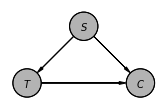

In [35]:
simp_model = BayesianNetwork([('S', 'T'), ('T', 'C'), ('S', 'C')])
simp_model.to_daft(node_pos={'T': (0, 0), 'C': (2, 0), 'S': (1, 1)}).render()

In [38]:
cpd_s = TabularCPD(variable='S',
                   variable_card=2,
                   values=[[0.5],
                           [0.5]],
                   state_names={'S': ['m', 'f']})
cpd_t = TabularCPD(variable='T',
                   variable_card=2,
                   values=[[0.25, 0.75],
                           [0.75, 0.25]],
                   evidence=['S'],
                   evidence_card=[2],
                   state_names={'S':['m', 'f'], 'T':[0, 1]})
cpd_c = TabularCPD(variable='C',
                   variable_card=2,
                   values=[[0.3, 0.4, 0.7, 0.8],
                           [0.7, 0.6, 0.3, 0.2]],
                   evidence=['S', 'T'],
                   evidence_card=[2, 2],
                   state_names={'S': ['m', 'f'], 'T': [0, 1], 'C': [0, 1]})

simp_model.add_cpds(cpd_s, cpd_t, cpd_c)

print(cpd_c)

# Non adjusted inference
infer_non_adjust = VariableElimination(simp_model)

print(infer_non_adjust.query(variables=['C'], evidence={'S': 1}))
print(infer_non_adjust.query(variables=['C'], evidence={'S': 0}))

+------+------+------+------+------+
| S    | S(m) | S(m) | S(f) | S(f) |
+------+------+------+------+------+
| T    | T(0) | T(1) | T(0) | T(1) |
+------+------+------+------+------+
| C(0) | 0.3  | 0.4  | 0.7  | 0.8  |
+------+------+------+------+------+
| C(1) | 0.7  | 0.6  | 0.3  | 0.2  |
+------+------+------+------+------+


Eliminating: T: 100%|██████████| 1/1 [00:00<00:00, 511.50it/s]


+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.7250 |
+------+----------+
| C(1) |   0.2750 |
+------+----------+


Eliminating: T: 100%|██████████| 1/1 [00:00<00:00, 742.88it/s]

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.3750 |
+------+----------+
| C(1) |   0.6250 |
+------+----------+


In [84]:
cpd_c.variables

['C', 'S', 'T']

In [81]:
np.set_printoptions(precision=3)

normalize(cpd_c.values[:, 0] @ cpd_t.values[0])
normalize(cpd_c.values[:, 1] @ cpd_t.values[1])

array([0.725, 0.275])